# 前言

本文的写作基本按照`Uday Bondhugula`的博士论文`Effective automatic parallelization and locality optimization using the polyhedral model`论文的顺序, 但目前只添加到第四章例子部分为止. 我认为原文的讲解非常深入浅出, 但是缺少了实操的部分, 因此我尽可能地为每个概念添加了可执行的代码以及可视化绘图, 希望这篇文章可以给大家入门多面体模型提供帮助:)

# 背景

首先让我们回忆一下线性代数相关的知识, 接下来所有的行向量使用粗体小写字母，列向量使用箭头标示。所有实数的集合为$\mathbb{R}$，一组有理数为$\mathbb{Q}$和整数集为$\mathbb{Z}$


## 线性方程(linear function)定义

一个$k$维的函数$f$定义如下:
$$
\text{linear function}\ f(\vec{v}) = M_f\vec{v}
$$

其中$M_f \in \mathbb{R}^{k×d}$为$k$行$d$列, $\vec{v} = \left( \begin{array}{l} v_1 \\ \vdots \\ v_d \end{array} \right)$. 在多面体编译中, 矩阵都是由整数组成$M_f \in \mathbb{Z}^{k\times d}$. 



假设目前空间的坐标基为$(1,0)$和$(0,1)$,现在我想把它变换为基为$(1,1)$和$(-1,1)$, 对应的变换矩阵为如下:

$$
M_f = \left[ \begin{array}{ll} -1 & 1 \\ 1 & 1  \end{array}  \right]
$$

在isl中可以通过如下方式表示:

In [1]:
import isl
from plot.plotter import plot_set_points, plot_map
import matplotlib.pyplot as plt

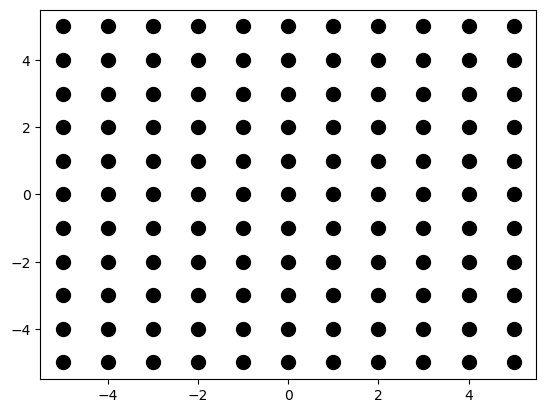

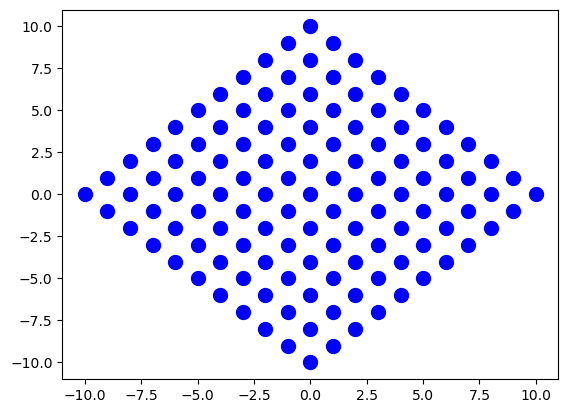

In [2]:
domain = isl.set("{ [x,y] : -5 <= x <= 5 and -5 <= y <= 5 }")
plt.figure(1)
plot_set_points(domain)
linear_trans = isl.map("{ [x,y] -> [x+y,-x+y] }")
plt.figure(2)
plot_set_points(domain.apply(linear_trans), color='blue')

当$k > d$时, 那么将把原始的空间映射到更高的维度:
 $$
M_f = \left[ \begin{array}{ll} -1 & 1 \\ 1 & 1 \\ 1 & -1  \end{array}  \right]
$$

在isl中可以通过如下方式表示:

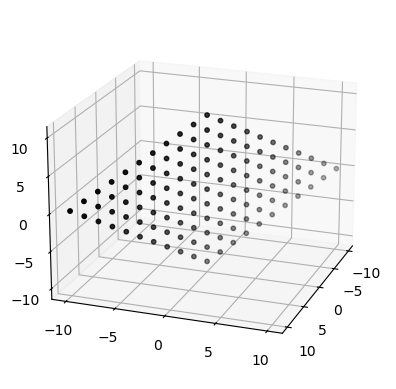

In [3]:
from plot.plotter3d import plot_set_points_3d
linear_trans = isl.map("{ [x,y] -> [x+y,-x+y,x-y] }")
ax = plot_set_points_3d(domain.apply(linear_trans))
ax.view_init(elev=20, azim=20)

## 仿射(affine)定义

一个$k$维的affine函数$f$定义如下:

$$
\text{affine function}\ f(\vec{v}) = M_f\vec{v} + \vec{f_0}
$$

与上面类似, 这里$\vec{f_0} \in \mathbb{Z}^k$是一个$k$维的整数向量. 


affine变换相比于线性变换多了平移部分, 假设在上文线性变换的例子上我们添加上向量:
$$
\vec{f_0} = \left( \begin{array}{l} 3 \\ -2  \end{array} \right)
$$

在isl中这样来表示:

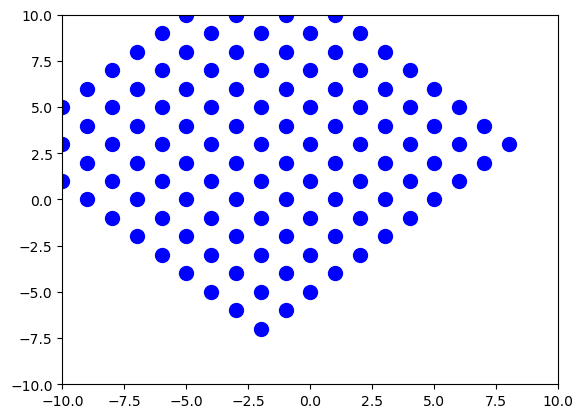

In [4]:
linear_trans = isl.map("{ [x,y] -> [x+y+3,-x+y-2] }")
plt.figure()
plt.xlim(-10,10)
plt.ylim(-10,10)
plot_set_points(domain.apply(linear_trans), color='blue')

## 零空间(null Space)定义

一个affine function $f(\vec{v}) = M_f(\vec{v}) + \vec{f_0}$的零空间是$f(\vec{v}) = \vec{0}$的所有解$M_f \in \mathbb{Z}^{k \times d}$的集合.

如果这个矩阵是列满秩的情况下, 那么零空间是0维.

## 仿射空间(affine space)定义

仿射空间是不考虑原点的向量空间

## 仿射超平面(Affine hyperplane)定义

仿射超平面是$n$维空间的$n-1$维仿射子空间. 在多面体编译中, 满足$\mathbf{h}.\vec{v} = k, k \in \mathbb{Z}, \vec{v} \in \mathbb{Z}^n$的$\vec{v}$的集合形成仿射超平面, 其中$\mathbf{h}$称为超平面的法向量. 如果两个向量$\mathbf{h}\cdot\vec{v}^1 = \mathbf{h}\cdot\vec{v}^2$, 那么他们就位于同一个仿射超平面.

对于不同的$k$的值,存在着不同的仿射超平面,但是因为他们之间是平行的, 所以法向量$\mathbf{h}$相同. 

仿射超平面也可以被视为一个一维的仿射函数,它将$n$维空间映射到一维空间. 或者说,它是将$n$维空间分割成$n-1$维的切片. 这种分割是通过将空间中的每个点映射到一个标量值来实现的,这个标量值是向量与法向量的点积加上一个常数$c$. 作为仿射函数时可以视为$M_f$行数为1,写成如下 :
$$\phi(\vec{v}) = \mathbf{h}\cdot(\vec{v}) + c$$

这里我们用一个三维几何视角的例子来说明, 假设此时$\mathbf{h} = (1,0,0), c = 2$:

{ [z, y, x] : x = -2 and -5 <= z <= 5 and -5 <= y <= 5 }


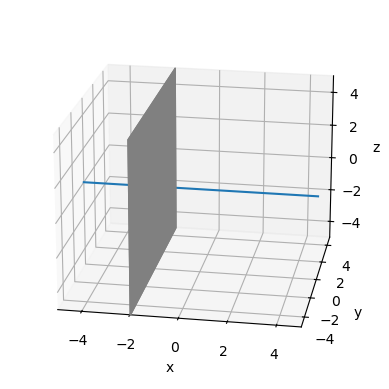

In [5]:
from plot.plotter3d import plot_set_shapes_3d
domain = isl.basic_set("{ [z,y,x] :  -5 <= x <= 5 and -5 <= y <= 5 and -5 <= z <= 5 }")
phi =  isl.basic_map("{ [z,y,x] -> [x'] : x' = 0 and x' = x + 2 }")
plane = phi.reverse().intersect_range(domain).range()
print(plane)
ax = plot_set_shapes_3d(plane)
ax.view_init(elev=20, azim=20)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.plot([-5,5],[0,0],[0,0], label=f'h')
ax.view_init(elev=20, azim=-80)

上面这段代码绘制了一个仿射超平面,其中蓝色线表示行向量$\mathbf{h}$, 平面本身代表$\phi(\vec{v})=k$, 平面左侧代表$\phi(\vec{v})\leq k$, 右侧代表$\phi(\vec{v}) \geq k$.

## Polyhedron,polytope定义

Polyhedron是有限数量的半空间的交点,也就是被多个仿射超平面分割出来的空间,polytope是有界的Polyhedron.

In [6]:
import isl
from plot.plotter import plot_map_as_groups, plot_set_points
from utils.common import CSource
from matplotlib import pyplot as plt

# 多面体模型

多面体模型本质上一个几何和线性代数框架, 通过线性代数抽象程序的语义并进行优化.

## 迭代向量(Iteration vector)定义

语句的迭代向量是由围绕该语句的所有从外到内循环的索引的值组成的向量. 定义程序中的语句为$S$, 对于的迭代向量表示为$\vec{i_S}$.

## 域(Domain)定义

给定语句的所有迭代向量的集合是该语句的域或索引集(Index Set), 通过$\mathcal{D}^S$表示语句为$S$的域.

参考这个例子:
```c
for (i=0; i<N; i++)
  for (j=0; j<N; j++)
    S1: A[i, j ] = A[i,j] + u1[i] * v1[j] + u2[i] * v2[j];

for (k=0; k<N; k++)
   for (l=0; l<N; l++)
     S2: x[k] = x[k]+ beta * A[l,k] * y[l];
```

对于S1, 迭代向量维度为$m_s$, 定义为$\vec{i_{S1}} = (i, j) \in \mathcal{D}^{S1}$. domain所对应的约束为
$$
\begin{aligned}
i & \geq 0 \\
-1+N-i & \geq 0 \\
j & \geq 0 \\
-1+N-j & \geq 0 \\
\end{aligned}
$$

在isl中使用矩阵的形式来表示这些约束:

In [7]:
from utils.isl_util import display_constraints
bset = isl.basic_set("[N] -> { S1[i,j] : 0 <= i < N and 0 <= j < N }")
display_constraints(bset)

(  CST  PARAM N  OUT i  OUT j
     0        0      1      0
    -1        1     -1      0
     0        0      0      1
    -1        1      0     -1,
 None)

# 多面体依赖(Polyhedral Dependences)

关于依赖的内容可以看我之前的文章[[Hands-On Polyhedral] Dependence Analysis](https://zhuanlan.zhihu.com/p/651475686). 这里就直接给出关于依赖的符号表示.


## 数据依赖图 Data Dependence Graph

数据依赖图$G=(V,E)$是一个有向图, 每个顶点代表一个语句,即$V = \mathbf{S}$. 每一个从$S_i$到$S_j$的边$e \in E$代表source到target的访问冲突. 上面这个例子的数据依赖图如下所示:

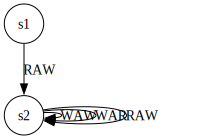

In [8]:
from graphviz import Digraph
g = Digraph(node_attr={'shape': 'record', 'height': '.1'})
g.node(f's1', label=f's1', shape='circle')
g.node(f's2', label=f's2', shape='circle')
g.edge('s1', 's2', 'RAW')
g.edge('s2', 's2', 'WAW')
g.edge('s2', 's2', 'WAR')
g.edge('s2', 's2', 'RAW')
g

## 依赖多面体 Dependence polyhedron

对于边$e$, 动态实例$S_i$到$S_j$的依赖关系由依赖性多面体$\mathcal{P}_e$捕获. 依赖多面体的维度是两个语句的参数维度之和. 如果$\vec{s}$和$\vec{t}$两个迭代向量存在依赖, 那么可以表示为:
$$
\langle\vec{s}, \vec{t}\rangle \in \mathcal{P}_e \quad \Longleftrightarrow \quad \vec{s} \in \mathcal{D}^{S_i}, \vec{t} \in \mathcal{D}^{S_j} \text { are dependent through edge } e \in E
$$

上面这段代码的依赖如下: 

$$
\begin{aligned}
i & \geq 0 \\
-j + N - 1 & \geq 0 \\
k & \geq 0 \\
-l + N - 1 & \geq 0 \\
i - l & = 0 \\
j - k & = 0
\end{aligned}
$$

我们可以使用isl计算依赖并打印出依赖多面体, 并绘制他:

In [9]:
write = isl.union_map("[N] -> { S1[i,j] -> A[i,j] : 0 <= i < N and 0 <= j < N }")
read = isl.union_map("[N] -> { S2[k,l] -> A[l,k] : 0 <= k < N and 0 <= l < N }")
sche = isl.union_map("{ S1[i,j] -> [0,i,j]; S2[k,l] -> [0,k,l];  }")
info = isl.union_access_info(read)
info = info.set_must_source(write)
info = info.set_schedule_map(sche)
flow = info.compute_flow()
raw = flow.must_dependence()
print("dep raw:", raw)
display_constraints(raw.as_map().basic_map_list().at(0))

dep raw: [N] -> { S1[i, j] -> S2[k = j, l = i] : i >= 0 and i < j < N }


(  CST  PARAM N  IN i  IN j  OUT k  OUT l
     0        0     1     0      0      0
    -1        0    -1     1      0      0
    -1        1     0    -1      0      0,
   CST  PARAM N  IN i  IN j  OUT k  OUT l
     0        0    -1     0      0      1
     0        0     0    -1      1      0)

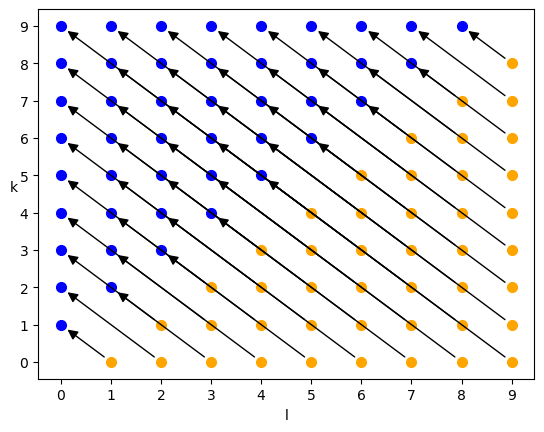

In [10]:
plot_map(raw.as_map().intersect_params(isl.set("[N] -> { : N = 10  } ")))

## 多面体变换(Polyhedral Transformations)

考虑一个一维的affine变换应用在语句$S$上, 这个仿射函数可以表示为如下:

$$
\begin{aligned}
 \phi_S(\vec{i}) & =\left(\begin{array}{llll}
c_1^S & c_2^S & \ldots & c_{m_S}^S
\end{array}\right)\left(\vec{i}_S\right)+c_0^S \\
& =\left(\begin{array}{lllll}
c_1^S & c_2^S & \ldots & c_{m_S}^S & c_0^S
\end{array}\right)\left(\begin{array}{c}
\vec{i}_S \\
1
\end{array}\right) \\
&
\end{aligned}
$$

其中$c_1^S, c_2^S, \ldots, c_{m_S}^S \in \mathbb{Z}, \vec{i} \in \mathbb{Z}^{m_s}$, 此处一维的仿射变换就对应一个仿射超平面.

多维的仿射变换使用上标表示每个级别的超平面, 令$\phi_{S}^{k}$表示对于语句$S$在级别$k$处的超平面.如果$1 \leq k \leq d$, 那么$\phi_{S}^{k}$就代表一个$d$维的仿射变换$\mathcal{T}_S$:

$$\mathcal{T}_S\vec{i_S} = M_S\vec{i_S} + \vec{f_0}$$

其中$M_S \in \mathbb{Z}^{d\times m_s}, \vec{f_0} \in \mathbb{Z}^d$.
$$
\mathcal{T}_S(\vec{i})=\left(\begin{array}{c}
\phi_S^1(\vec{i}) \\
\phi_S^2(\vec{i}) \\
\vdots \\
\phi_S^d(\vec{i})
\end{array}\right)=\left(\begin{array}{cccc}
c_{11}^S & c_{12}^S & \ldots & c_{1 m_S}^S \\
c_{21}^S & c_{22}^S & \ldots & c_{2 m_S}^S \\
\vdots & \vdots & \vdots & \vdots \\
c_{d 1}^S & c_{d 2}^S & \ldots & c_{d m_S}^S
\end{array}\right) \vec{i}_S+\left(\begin{array}{c}
c_{10}^S \\
c_{20}^S \\
\vdots \\
c_{d 0}^S
\end{array}\right)
$$


对于仿射变换$\mathcal{T}_S$的维度$d$, 他实际上是可以大于迭代向量的维度$m_S$, 多出来的维度我们可以用于表示fuse或者fission. 称之为**标量维度**.

接下来看一个实际的例子, 考虑下面这段代码:
 
```c
for (i=0; i<n; i++) { 
  for (j=0; j<n; j++) { 
    for (k=0; k<n; k++) { 
      S1: C[i, j ] = C[i,j ] + A[i,k] * B[k,j ]; 
    } 
  } 
} 
for (i=0; i<n; i++) {
  for (j=0; j<n; j++) { 
    for (k=0; k<n; k++) { 
      S2: D[i, j ] = D[i,j ] + E[i,k] * C[k,j ]; 
    } 
  }
}
```

我们将使用如下的矩阵对其进行变换, 最终得到fused版本:

$$
\begin{aligned}
& T_{S_1}\left(\vec{i}_{S_1}\right)=\left(\begin{array}{lll}
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 1
\end{array}\right)\left(\begin{array}{l}
i \\
j \\
k
\end{array}\right)+\left(\begin{array}{l}
0 \\
0 \\
0 \\
0
\end{array}\right)
= \left(\begin{array}{l}
j \\
i \\
0 \\
k
\end{array}\right)\\
& T_{S_2}\left(\vec{i}_{S_2}\right)=\left(\begin{array}{lll}
0 & 1 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0 \\
1 & 0 & 0
\end{array}\right)\left(\begin{array}{l}
i \\
j \\
k
\end{array}\right)+\left(\begin{array}{l}
0 \\
0 \\
1 \\
0
\end{array}\right)
= \left(\begin{array}{l}
j \\
k \\
1 \\
i
\end{array}\right)
\end{aligned}
$$


In [11]:
from utils.isl_util import schedule_to_code
domain_1 = isl.union_set("[n] -> { S1[i,j,k]: 0 <= i < n and 0 <= j < n and 0 <= k < n; }")
domain_2 = isl.union_set("[n] -> { S2[i,j,k]: 0 <= i < n and 0 <= j < n and 0 <= k < n;  }")
trans_1 = isl.union_map("{ S1[i,j,k] -> [j,i,0,k];  }")
trans_2 = isl.union_map("{ S2[i,j,k] -> [j,k,1,i]; }")
schedule_to_code(domain_1.union(domain_2), trans_1.union(trans_2))

```c
for (int c0 = 0; c0 < n; c0 += 1)
  for (int c1 = 0; c1 < n; c1 += 1) {
    for (int c3 = 0; c3 < n; c3 += 1)
      S1(c1, c0, c3);
    for (int c3 = 0; c3 < n; c3 += 1)
      S2(c3, c0, c1);
  }

```

# 合法性和并行性

基于上文, 我们已经有了程序抽象表示以及操作程序变换的工具. 接下来我们需要考虑程序分析.

## 依赖满足 (Dependence satisfaction)

一个多面体$\mathcal{P}_e$的依赖边$e$在层级$l$满足, 当且仅当$l$是第一个级别, 且满足下面的条件:
$$
\begin{aligned} 
\forall(1 \leq k \leq l - 1) : \phi(\vec{t})_{S_j}^{k} - \phi(\vec{s})_{S_i}^{k} \geq 0 \land \phi(\vec{t})_{S_j}^{l} - \phi(\vec{s})_{S_i}^{l} \geq 1, \left<\vec{s},\vec{t}\right> \in \mathcal{P}_e
\end{aligned}
$$

在`Optimizing Compilers for Modern Architectures`中有提到, 依赖的有效性需要满足最左边开始第一个非0元素必须满足sink在source之后的约束.

## 合法性 (Legality)

对于一个语句的仿射变换$\mathcal{T}_S$必须要满足:

$$
\begin{aligned}
T_{S_j}(\vec{t}) - T_{S_i}(\vec{s}) \succ \vec{0}_d, \left<\vec{s},\vec{t} \right> \in \mathcal{P}_e, \forall e \in E
\end{aligned}
$$

也就是对于每对依赖来说, 仿射变换必须要保证原本的执行先后顺序.

## 可交换带 (Permutable band)

当位于level $p,p+1,\ldots,p+s-1$ 仿射变换$\phi s$满足如下条件时, 称之为Permutable band:

$$
\forall(p \leq k \leq p + s - 1): \phi_{S_j}^k(\vec{t}) - \phi_{S_i}^k(\vec{s}) \geq 0,  \left<\vec{s},\vec{t} \right> \in \mathcal{P}_e, \forall e \in E_p
$$

其中$E_p$是一组不满足level $p-1$的依赖集合. 也就是在Permutable band内的循环, 可以任意交换而不会破坏依赖满足性.

## 外层并行 (Outer parallel)

当$\left\{ \phi_{S_1},\phi_{S_2},\ldots,\phi_{S_m}\right \}$满足如下条件时, 称之为是外层并行超平面:

$$\phi_{S_j}(\vec{t}) - \phi_{S_i}(\vec{s}) = 0, \left<\vec{s},\vec{t} \right> \in \mathcal{P}_e, \forall e \in E$$


基于下面这个代码分析:

```c
for (i=0;i<N;i++) {
  for (j=0;j<N;j++) { 
S1:    a[i][j] =a[i][j-1] + 1;
  }
}

```

{ S1[i, j] -> S1[i' = i, j' = 1 + j] }


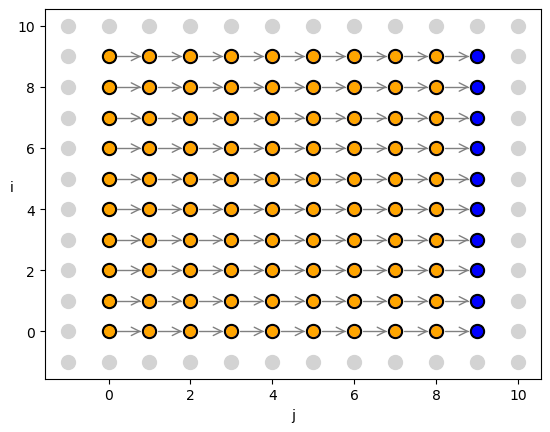

In [12]:
from plot.plotter import plot_domain


domain = isl.set("[N] -> { S1[i,j] : 0 <= i < N and 0 <= j < N }")
sche = isl.union_map("{ S1[i,j] -> [i,j] }")
read = isl.union_map("{ S1[i,j] -> a[i,j-1] }")
write = isl.union_map("{ S1[i,j] -> a[i,j] }")
info = isl.union_access_info(read)
info = info.set_must_source(write)
info = info.set_schedule_map(sche)
flow = info.compute_flow()
raw = flow.get_must_dependence()
print(raw)
param = isl.set("[N] -> { : N = 10 }")
plot_domain(domain.intersect_params(param).as_set(), raw.intersect_params(param).as_map())

当前的迭代向量为$\vec{t} = \left(\begin{array}{l} i \\ j \end{array} \right)$,$\vec{s} = \left(\begin{array}{l} i \\ j+1 \end{array} \right)$, 通过观察依赖可以发现当法向量$\mathbf{h} = \left(\begin{array}{ll}1 & 0 \end{array}\right)$时, 这些超平面之间没有穿过任何的依赖向量. 如下图所示, 红色向量为法向量, 黑色向量表示超平面:

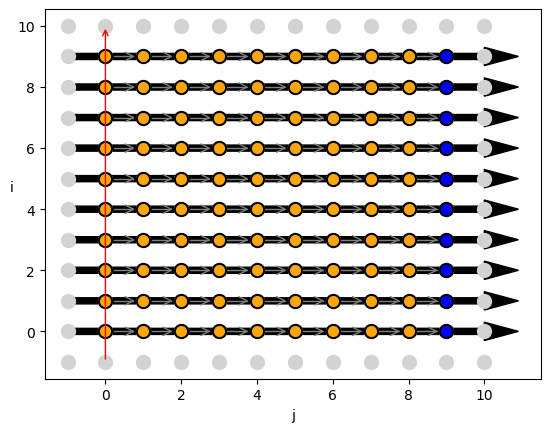

In [13]:
plot_domain(domain.intersect_params(param).as_set(), raw.intersect_params(param).as_map())
plt.annotate("", xy=(0, 10), xytext=(0, -1), arrowprops=dict(arrowstyle="->", color='red'))
for i in range(10):
  plt.arrow(-1,0+i,11,0,color='black',width=0.2)




代入仿射超平面公式中, 得到:

$$ \phi_{S_1}(\vec{i}) = \left(\begin{array}{ll}1 & 0 \end{array}\right)(\vec{i}) + c_0 $$

那么得到
 
$$
\begin{aligned} 
  \phi_{S_1}(\vec{t}) - \phi_{S_1}(\vec{s}) &= \left(\left(\begin{array}{ll}1 & 0 \end{array}\right)\left(\begin{array}{l} i \\ j \end{array} \right) + c_0  \right)- \left(\left(\begin{array}{ll}1 & 0 \end{array}\right)\left(\begin{array}{l} i \\ j+1 \end{array} \right) + c_0 \right) \\
  &= \left(i + c_0\right) - \left(i + c_0\right) \\
  &= 0  

\end{aligned}
$$

## 内层并行 (Inner parallel)

当$\left\{ \phi_{S_1},\phi_{S_2},\ldots,\phi_{S_m}\right \}$满足如下条件时, 称之为是内层并行超平面:

$$\phi_{S_j}(\vec{t}) - \phi_{S_i}(\vec{s}) = 0, \left<\vec{s},\vec{t} \right> \in \mathcal{P}_e, \forall e \in E_k$$

其中$E_k$是不满足$k-1$级的一组依赖集合. 由于移动循环到新位置的时候可能会破坏依赖满足性, 所以把内层并行循环移动到外层方向会是非法的. 但是如果把内层循环向更内层移动是合法的, 需要注意的是内层并行性需要每次外部迭代都进行同步.

基于下面这个代码分析:

```c
for (i=0;i<N;i++) {
  for (j=0;j<N;j++) { 
S1:    a[i][j] = a[i-1][N-j-1] + 1;
  }
}

```



[N] -> { S1[i, j] -> S1[i' = 1 + i, j' = -1 + N - j] }


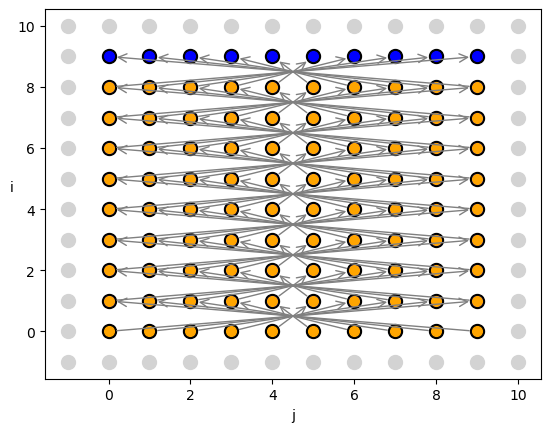

In [14]:
domain = isl.set("[N] -> { S1[i,j] : 0 <= i < N and 0 <= j < N }")
sche = isl.union_map("{ S1[i,j] -> [i,j] }")
read = isl.union_map("[N] -> { S1[i,j] -> a[i-1,N-j-1] }")
write = isl.union_map("{ S1[i,j] -> a[i,j] }")
info = isl.union_access_info(read)
info = info.set_must_source(write)
info = info.set_schedule_map(sche)
flow = info.compute_flow()
raw = flow.get_must_dependence()
print(raw)
param = isl.set("[N] -> { : N = 10 }")
plot_domain(domain.intersect_params(param).as_set(), raw.intersect_params(param).as_map())

当前的迭代向量为$\vec{t} = \left(\begin{array}{l} i \\ j \end{array} \right)$,$\vec{s} = \left(\begin{array}{l} i + 1 \\ N - j - 1 \end{array} \right)$, 通过观察依赖可以发现当法向量$\mathbf{h} = \left(\begin{array}{ll} 0 & 1 \end{array}\right)$时, 这些超平面之间没有穿过任何的依赖向量. 如下图所示, 红色向量为法向量, 黑色向量表示超平面:

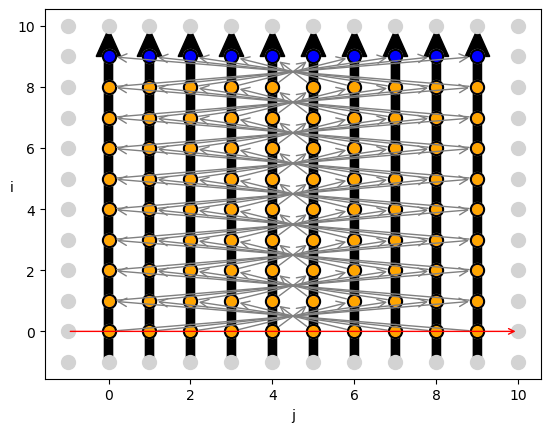

In [15]:
plot_domain(domain.intersect_params(param).as_set(), raw.intersect_params(param).as_map())
plt.annotate("", xy=(10, 0), xytext=(-1, 0), arrowprops=dict(arrowstyle="->", color='red'))
for i in range(10):
  plt.arrow(i,-1,0,10,color='black',width=0.2)

## 流水并行性 (Pipelined parallelism)

两个或多个循环可能都有关于自己的依赖分量但是当他们其中一个可以被另一个循环的固定数来延迟, 这个时候他们也可以被并行执行.

考虑这段代码的依赖性,连续的迭代`i`必须等待`j`执行一次才能开始:
```c
for (i=0;i<N;i++) { 
  for (j=0;j<N;j++) { 
  S1:  a[i][j] = a[i][j-1] + a[i-1][j];
  }
}
```

[N] -> { S1[i, j] -> S1[i' = i, j' = 1 + j]; S1[i, j] -> S1[i' = 1 + i, j' = j] }


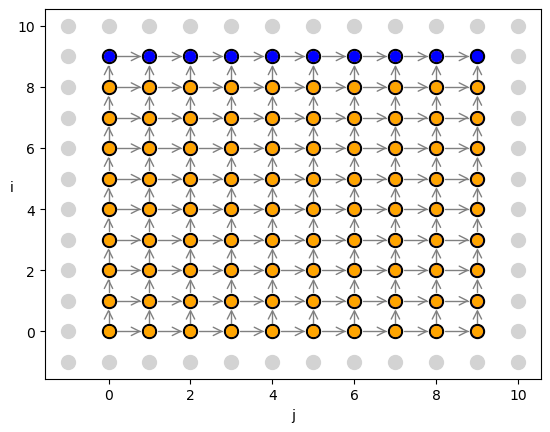

In [16]:
domain = isl.set("[N] -> { S1[i,j] : 0 <= i < N and 0 <= j < N }")
sche = isl.union_map("{ S1[i,j] -> [i,j] }")
read = isl.union_map("[N] -> { S1[i,j] -> a[i-1,j]; S1[i,j] -> a[i,j-1]; }")
write = isl.union_map("{ S1[i,j] -> a[i,j] }")
info = isl.union_access_info(read)
info = info.set_must_source(write)
info = info.set_schedule_map(sche)
flow = info.compute_flow()
raw = flow.get_must_dependence()
print(raw)
param = isl.set("[N] -> { : N = 10 }")
plot_domain(domain.intersect_params(param).as_set(), raw.intersect_params(param).as_map())

## 时间空间映射 (Space-time mapping)

当仿射变换$\mathcal{T}_S$的每一行可以被标记为`space`和`time`, `space`表示这个维度迭代在不同的处理器上执行,`time`表示这个迭代在同一个处理器上按顺序执行.

# 基于并行性和局部性的自动变换 (Automatic Transformations for Parallelism and Locality)

自动变换的目标就是找到$\mathcal{T}_S, \forall S \in \mathbf{S}$中一组未知的系数. 进一步还需要决定仿射变换的每一行是`space`还是`time`.

## 多面体模型中的tiling合法性

tiling是优化数据局部性和并行性的关键优化手段. tiling对于优化数据局部性需要将一组迭代空间中的一组点组合到一个小的block中, 这个block契合于更快的内存(L1,L2,L3), 并且允许在不同的迭代方向上重用他. tiling对于粗粒度的并行会涉及在迭代空间上切分到在多个处理器上并行执行的tile上, 此时需要考虑在不同处理器上通信量的大小. 本文所提出的转换框架的一个关键特性就是考虑到如何更好的处理tiling.

tiling超平面$\{ \phi_{S_1},\phi_{S_2},\ldots,\phi_{S_k} \}$的合法性为:
$$
\phi_{S_j}(\vec{t}) - \phi_{S_i}(\vec{s}) \geq 0, \left<\vec{s},\vec{t}\right> \in \mathcal{P}_e
$$ 

如果每个tile可以原子的执行并且可以构造全部tile的有效顺序,那么可以说明由这些tiling超平面定义tiling是合法的, 这意味任意两个tile不存在相互影响. 从几何的角度来理解, 即tiling超平面的法向量和依赖向量的夹角要小于等于90度. 
 
假设$\{ \phi_{S_1}^2,\phi_{S_2}^1,\ldots,\phi_{S_k}^1 \}$和$\{ \phi_{S_1}^2,\phi_{S_2}^2,\ldots,\phi_{S_k}^2 \}$是两个满足tiling超平面的一维仿射变换, tile就是由超平面$\phi^1$和$\phi^2$围起来的点组成.


考虑一个1维Jacobi的例子:
```cpp
for (t = 0; t < T; t++) {
  for (i = 2; i < N − 1; i++) {
    a[t, i] = 0.333 * (a[t− 1, i] + a[t− 1, i− 1] + a[t− 1, i + 1]);
  }
}
```

dependencies: [T, N] -> { s1[t, i] -> s1[t' = 1 + t, i' = 1 + i] : T = 7 and N = 11 and 0 <= t <= 6 and 2 <= i <= 9; s1[t, i] -> s1[t' = 1 + t, i' = i] : T = 7 and N = 11 and 0 <= t <= 6 and 2 <= i <= 9; s1[t, i] -> s1[t' = 1 + t, i' = -1 + i] : T = 7 and N = 11 and 0 <= t <= 6 and 2 <= i <= 9 }


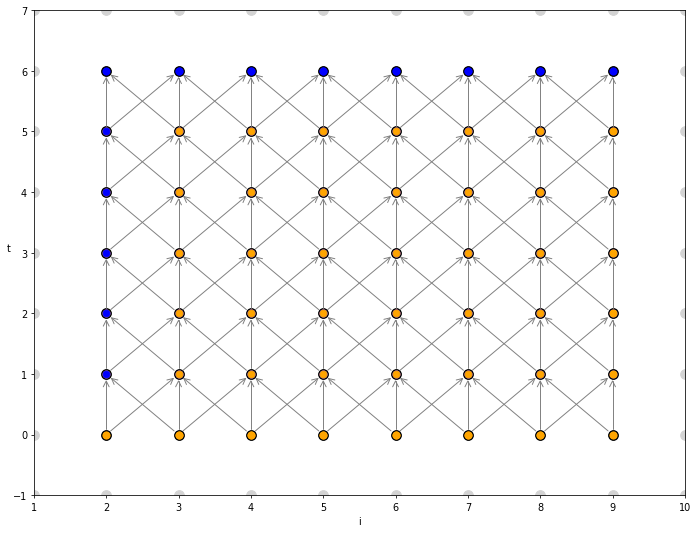

In [17]:
param = isl.set("[T, N] -> { : T = 7 and N = 11 }")
domain = isl.union_set('[T,N] -> { s1[t,i]: 0 <= t < T and 2 <= i < N - 1 }').intersect_params(param)
read = isl.union_map("{ s1[t,i] -> a[t-1,i]; s1[t,i] -> a[t-1,i-1]; s1[t,i] -> a[t-1,i+1]; } ")
write = isl.union_map("{ s1[t,i] -> a[t,i]; }")
schedule = isl.union_map(" { s1[t,i] -> [t,i] } ")
info = isl.union_access_info(read)
info = info.set_must_source(write)
info = info.set_schedule_map(schedule)
flow = info.compute_flow()
raw = flow.get_must_dependence()
dep = raw.intersect_domain(domain)
plt.figure(figsize=(12,9), dpi=70)
plt.xlim(1, 10)
plt.ylim(-1, 7)
dep_map = dep.as_map()
print("dependencies:", dep_map)
domain = domain.as_set()
plot_domain(domain, dep_map)

此时的依赖边$\left<\vec{s},\vec{t}\right>$分别为:
$$\left<\left(\begin{array}{l}t \\ i \end{array}\right), \left(\begin{array}{l}t+1 \\ i-1 \end{array}\right)\right>, \left<\left(\begin{array}{l}t \\ i \end{array}\right), \left(\begin{array}{l}t+1 \\ i+1 \end{array}\right)\right>,
\left<\left(\begin{array}{l}t \\ i \end{array}\right), \left(\begin{array}{l}t+1 \\ i \end{array}\right)\right>$$

假设当前的tiling超平面分别为$\phi^1 = \left(1\ 0\right)$,$\phi^2 = \left(0\ 1\right)$, 代入tiling超平面合法性约束:

$$
\begin{array}{l}
\left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t+1 \\ i-1 \end{array}\right) - \left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 1 \\
\left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t+1 \\ i+1 \end{array}\right) - \left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 1 \\
\left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t+1 \\ i \end{array}\right) - \left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 1 \\
\left(\begin{array}{ll} 0 & 1 \end{array}\right) \left(\begin{array}{l}t+1 \\ i-1 \end{array}\right) - \left(\begin{array}{ll} 0 & 1 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = -1 \\
\left(\begin{array}{ll} 0 & 1 \end{array}\right) \left(\begin{array}{l}t+1 \\ i+1 \end{array}\right) - \left(\begin{array}{ll} 0 & 1 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 1 \\
\left(\begin{array}{ll} 0 & 1 \end{array}\right) \left(\begin{array}{l}t+1 \\ i \end{array}\right) - \left(\begin{array}{ll} 0 & 1 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 0 \\
\end{array}
$$

我们可以发现当前的tiling超平面会使得有一对依赖违反合法性, 所以这种tiling是不合法的. 下面使用isl可以明显看出这种tiling的不合法性, 也就是两个tile之间存在着相互依赖:


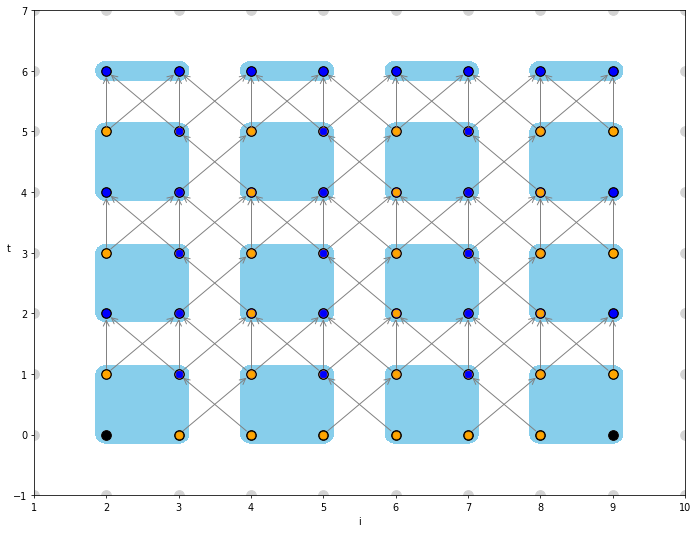

In [18]:
plt.figure(figsize=(12,9), dpi=70)
plt.xlim(1, 10)
plt.ylim(-1, 7)
tiling = isl.basic_map("{ s1[t,i] -> [floor(t/2),floor(i/2)] }")
plot_domain(domain, dep_map, tiling)

假设当前的tiling超平面分别为$\phi^1 = \left(1\ 0\right)$,$\phi^2 = \left(1\ 1\right)$, 代入tiling超平面合法性约束:

$$
\begin{array}{l}
\left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t+1 \\ i-1 \end{array}\right) - \left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 1 \\
\left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t+1 \\ i+1 \end{array}\right) - \left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 1 \\
\left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t+1 \\ i \end{array}\right) - \left(\begin{array}{ll} 1 & 0 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 1 \\
\left(\begin{array}{ll} 1 & 1 \end{array}\right) \left(\begin{array}{l}t+1 \\ i-1 \end{array}\right) - \left(\begin{array}{ll} 1 & 1 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 0 \\
\left(\begin{array}{ll} 1 & 1 \end{array}\right) \left(\begin{array}{l}t+1 \\ i+1 \end{array}\right) - \left(\begin{array}{ll} 1 & 1 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 2 \\
\left(\begin{array}{ll} 1 & 1 \end{array}\right) \left(\begin{array}{l}t+1 \\ i \end{array}\right) - \left(\begin{array}{ll} 1 & 1 \end{array}\right) \left(\begin{array}{l}t \\ i \end{array}\right) = 1 \\
\end{array}
$$

现在完全满足tiling超平面约束,通过isl可以绘制出这个合法的tiling方式:

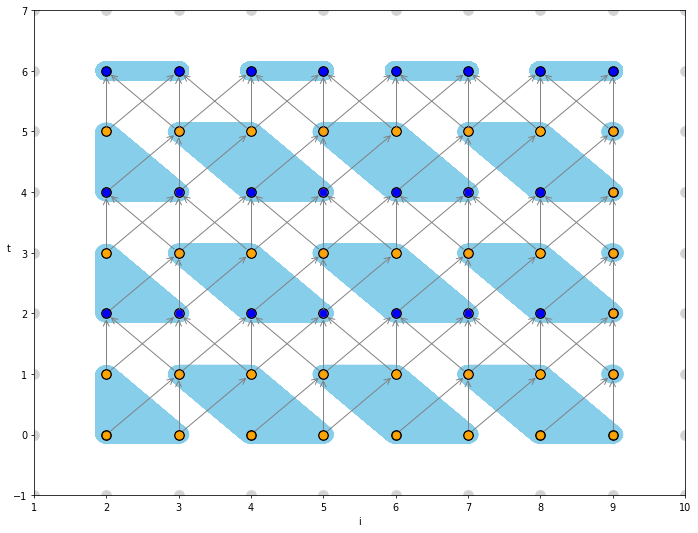

In [19]:
plt.figure(figsize=(12,9), dpi=70)
plt.xlim(1, 10)
plt.ylim(-1, 7)
aff = isl.map("{ s1[t,i] -> s1[t,i-t] }")
plot_domain(domain, dep_map, tiling.apply_domain(aff))


## tiling 合法性约束线性化

回忆上文的`tiling`合法性约束, 他的affine形式可以写成如下:
$$
\left(c_1^{S_j},c_2^{S_j},\ldots,c_{m^{S_j}}^{S_j} \right)\vec{t} - \left(c_1^{S_i},c_2^{S_i},\ldots,c_{m^{S_i}}^{S_i} \right)\vec{s} \geq 0, \left<\vec{s},\vec{t}\right> \in \mathcal{P}_e
$$

如果当依赖的距离向量中存在循环变量组成时, 上面的约束是非线性形式, 而使用Farkas引理可以等效地表示为依赖性多面体中的非负线性组合形式:

$$
\left(c_1^{S_j},c_2^{S_j},\ldots,c_{m^{S_j}}^{S_j} \right)\vec{t} - \left(c_1^{S_i},c_2^{S_i},\ldots,c_{m^{S_i}}^{S_i} \right)\vec{s} \equiv \lambda_{e_0} + \sum_{k=1}^{m_e}\lambda_{e_{k}}\mathcal{P}_e^k, \lambda_{e_{k}} \geq 0 
$$

其中$m_e$表示依赖个数,$\lambda_{e_{k}}$是新引入的farkas因子, 在后面可以使用高斯消去法或 Fourier-Motzkin 消去法删除.

<!-- 转换后形式lhs和rhs上循环变量的系数将 -->

<!-- A [m,n] -->
<!-- 回忆farkas引理的定义, 
1. 存在$\vec{x} \in \mathbb{R}^n$,使得$A \vec{x} = \vec{b}$, 且$\vec{x} \geq 0$
2. 存在$\vec{y} \in \mathbb{R}^m$,使得$A^T \vec{y} \geq 0$ , 且$ \vec{b}^T  \vec{y} < 0$
 -->

## 寻找更优解

继续考虑1维Jacobi的例子, 他们的依赖向量$\vec{t}-\vec{s}$分别为$\left(\begin{array}{l}1 \\ 0 \end{array}\right), \left(\begin{array}{l}1 \\ 1 \end{array}\right), \left(\begin{array}{l}1 \\ -1 \end{array}\right)$. 代入到tiling超平面约束中得到:
$$
\left(\begin{array}{ll} c_t & c_i \end{array}\right) \left(\begin{array}{l}1 \\ 0 \end{array}\right) \geq 0 ;\ 
\left(\begin{array}{ll} c_t & c_i \end{array}\right) \left(\begin{array}{l}1 \\ 1 \end{array}\right) \geq 0 ;\ 
\left(\begin{array}{ll} c_t & c_i \end{array}\right) \left(\begin{array}{l}1 \\ -1 \end{array}\right) \geq 0;\ 
$$
即:
$$
\begin{array}{l}
c_t \geq 0 \\
c_t + c_i \geq 0 \\
c_t - c_i \geq 0
\end{array}
$$

在这个解空间上存在着无数的可行解, 为了得到性能更优的解, 我们需要一个目标函数来指导优化方向. 我理解`Pluto`是设定了一个场景, 假定在`space`维度上, 多个`tile`在不同的处理器上是并行执行的, 且他们之间的依赖将会发生数据通信, 那么可以把通信量作为优化的目标函数. 

假设当前的`space`映射为$(1,0)$,`time`映射为$(1,1)$, 那么每一行的`tile`都属于同一个处理器, 我使用`isl`将在同一处理器上执行的`tile`填充为同一个颜色, 然后使用红色线来标记一个内`tile`, 不同处理器间所传输的数据点:

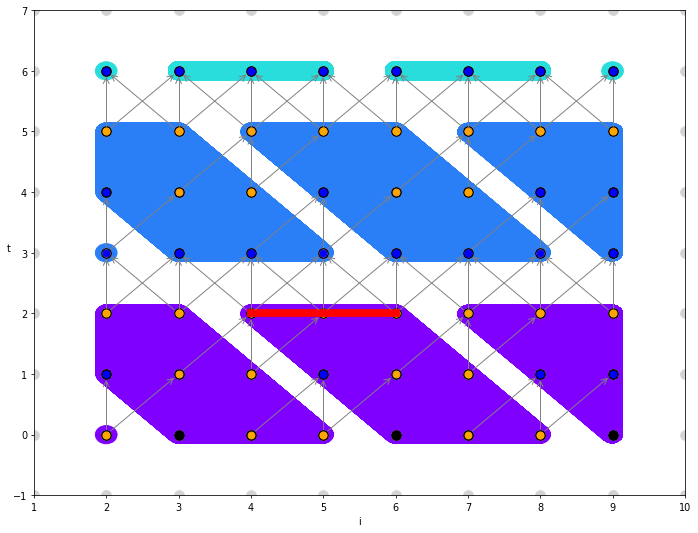

In [20]:
from plot.plotter import ProcessorMap
import numpy as np
plt.figure(figsize=(12, 9), dpi=70)
plt.xlim(1, 10)
plt.ylim(-1, 7)
aff = isl.map("{ s1[t,i] -> s1[t,i-t] }")
tiling = isl.basic_map("{ s1[t,i] -> [floor(t/3),floor(i/3)] }")
plot_domain(domain, dep_map, tiling.apply_domain(aff), processors_mapping=ProcessorMap(
    isl.set("[P] -> { [t,i]: t = P}"), range(7)), tile_color='rainbow')
_ = plt.plot(np.arange(4, 7), np.ones(3)*2, color='red', linewidth=8)

此时我们换一个映射方式, `space`映射为$(1,1)$, `time`映射为$(1,0)$, 由于我在绘制时`domain`坐标系是原始的, 而`tile`的坐标系是变换过的, 所以这里的对于处理器的映射超平面直接为列向量`{ [t,i]: i = P }`, 并且在图中看到的是倾斜的, 而使用红线标记的传输数据点将进一步增多: 

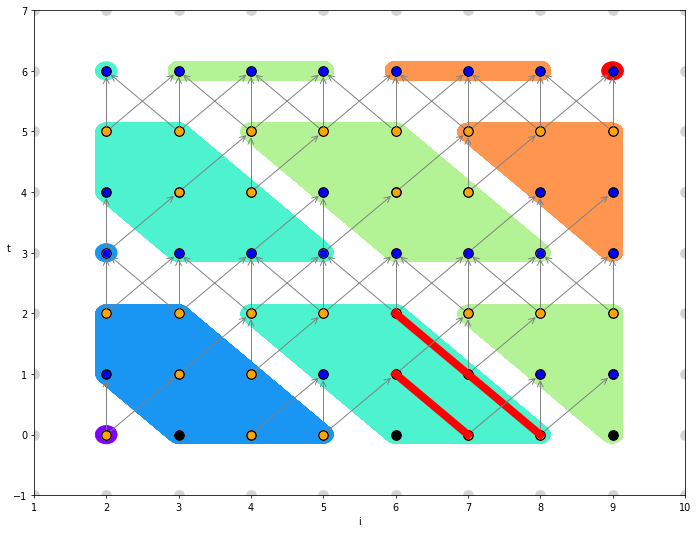

In [21]:
plt.figure(figsize=(12,9), dpi=70)
plt.xlim(1, 10)
plt.ylim(-1, 7)
aff = isl.map("{ s1[t,i] -> s1[t,i-t] }")
tiling = isl.basic_map("{ s1[t,i] -> [floor(t/3),floor(i/3)] }")
plot_domain(domain, dep_map, tiling.apply_domain(aff), processors_mapping=ProcessorMap(isl.set("[P] -> { [t,i]: i = P}"), range(6)), tile_color='rainbow')
_ = plt.plot(np.arange(6, 8), np.arange(1,-1,-1), color='red', linewidth=8)
_ = plt.plot(np.arange(6, 9), np.arange(2,-1,-1), color='red', linewidth=8)

再令`space`映射为$(2,1)$, `time`映射为$(1,0)$, 那么被标记的通信点的数据量又进一步增加了:

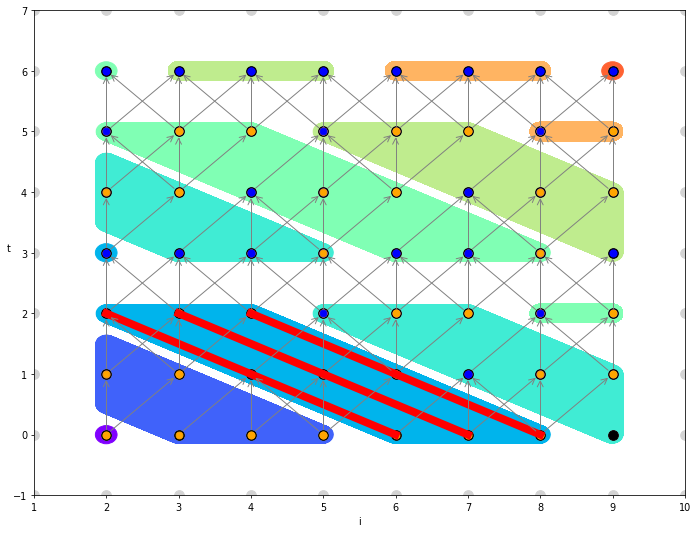

In [22]:
plt.figure(figsize=(12,9), dpi=70)
plt.xlim(1, 10)
plt.ylim(-1, 7)

aff = isl.map("{ s1[t,i] -> s1[t,i-2t] }")
tiling = isl.basic_map("{ s1[t,i] -> [floor(t/3),floor(i/3)] }")
plot_domain(domain, dep_map, tiling.apply_domain(aff), processors_mapping=ProcessorMap(isl.set("[P] -> { [t,i]: i = P}"), range(9)), tile_color='rainbow')
for i in range(2, 5):
  plt.plot([i + j*2 for j in range(3)], range(2, -1,-1), color='red', linewidth=8)

## Cost Function
基于上述观察, `Pluto`提出了一个cost function作为优化目标:
$$
\delta_e(\vec{s},\vec{t}) = \phi_{S_j}(\vec{t}) - \phi_{S_i}(\vec{s}), \left<\vec{s},\vec{t}\right> \in \mathcal{P}_e
$$

这个函数记录了依赖穿过一维仿射变换$\phi$所对应的`tiling`超平面的个数. 当$\phi$映射到`time`维度时, 代表了数据被重用的时间间隔; 当$\phi$被映射到`space`维度时, 代表了`tile`之间需要进行通信的数据量的粗略估计, 也就是上面图中的红线. 在2维空间中比较容易理解, 假设类似上面例子中, $\phi_{S_i}$和$\phi_{S_j}$相同, 那么此时$\delta_e = \phi_{S}(\vec{t} - \vec{s})$, 即法线与依赖向量的`cos`值, 当法线与依赖向量夹角越小, 那么意味着穿过的超平面的依赖向量越多, 而垂直时穿过的数量最少.

在上一节提到过使用Farkas引理来消除约束中循环变量的方法, 同样地, $\delta_e$作为cost function时也会引入循环变量和未知的仿射系数, 最终无法求解. 

Pluto假设当前所有的迭代空间有界, 那么程序中所有的结构参数向量$\vec{n}$将为所有的依赖的$\delta_e(\vec{s}, \vec{t})$给出上界, 即存在:
$$
v(\vec{n}) = \mathbf{u}.\vec{n} + w
$$

使得:
$$
\begin{align}
v(\vec{n}) - (\phi_{S_j}(\vec{t}) - \phi_{S_i}(\vec{s})) \geq & 0 \\
(\mathbf{u}.\vec{n} + w) - \delta_e(\vec{s},\vec{t}) \geq & 0, \left<\vec{s},\vec{t}\right> \in \mathcal{P}_e, \forall e \in E
\end{align}
$$

同样上面这个式子存在未知变量时也可以使用Farkas引理进行简化, 其中$\mathcal{P}_e^k$表示的是这个依赖多面体中的一行:
$$
\mathbb{u} \vec{n}+w-\delta_e(\vec{s}, \vec{t}) \equiv \lambda_{e 0}+\sum_{k=1}^{m_e} \lambda_{e k} \mathcal{P}_e^k, \quad \lambda_{e k} \geq 0
$$

Pluto论文中并没有给出严格的证明, 这里我的理解是, 其中$\phi(\vec{t})$与$\phi(\vec{s})$都是对两个迭代向量进行仿射变换的形式, 当迭代空间有界时, 这两个迭代向量仿射变换的差值肯定是小于他们对应上界的仿射变换的差值的.  

此时所有的线性不等式都已经给出, Pluto按$\mathbb{u}$和$w$以及仿射系数$c_{m_S}^S$的顺序, 求解他们的词典序最小值:
$$
minimize_{≺} (u_1,u_2,\ldots,u_k,w,c_i,\ldots)
$$

寻找词典序最小即优先求解出$u_k$为0的解, 那么就表示优先求解出$\delta_e(\vec{s},\vec{t})$为0的解, 也就是可并行的仿射变换. 

为了避免求出全0解, Pluto还添加了$\sum_{i=1}^{m^S}c_i^S >= 0$的约束, 这个约束也限制了Pluto求解出循环反转的仿射变换.

## 迭代求得线性无关解

Pluto使用ILP工具来求解, 需要求解每一个语句的仿射变换矩阵, 同时仿射变换矩阵都要逐行求解. 每一行求解出来后, 将他作为新的约束放到下一项中求解, 这样来保证仿射变换矩阵每一行之间的线性无关性. 我理解如果仿射超平面是线性相关的, 那么两个迭代变量的调度将会线性相关, 这就不是一个合法的调度了.

假设$H_S$矩阵的行表示语句$S$到目前为止的解, 那么他的正交子空间为:
$$
H_S^{\bot} = I - H_S^T(H_S H_S^T)^{-1}H_S
$$

此时$H_S^{\bot} H_S^T = \mathbb{0}$, 即$H_S$中的每一行都和$H_S^{\bot}$中的行正交. 那么为了找到一个和$H_S$中的每一行不正交的行向量, 那么我们就需要限制它不与$H_S^{\bot}$正交, 在二维空间比较好理解, A与B正交,为了避免A与C同方向,那么B与C也不能正交. 假设$h^*_S$为语句$S$下一个要求解的行, ${H^i}_S^{\bot}$为$H_S^{\bot}$中非零行, 添加$\forall i, {H^i}_S^{\bot}.  \vec{h}^*_S > 0, {H^i}_S^{\bot}.\vec{h}^*_S < 0$的约束. 

在Pluto中, 出于减少搜索域的原因, 限制上面的约束局限于正交空间的子空间, 也就是要求所有约束都是正的, 所以真正被添加的线性独立约束公式为:

$$
\forall i, {H^i}_S^{\bot}.  \vec{h}^*_S \geq 0 \  \land \ \sum_i {H^i}_S^{\bot} . \vec{h}^*_S \geq 1
$$

下面来看一个例子, 假设第一行求解出来为$(1,0,0)$, 那么给下一行超平面所添加的约束如下:
$$
\begin{align}
H_S & = (1,0,0) \\
H_S^{\bot}  & = I - H_S^T(H_S H_S^T)^{-1}H_S = \left( \begin{array}{lll} 0 & 0 & 0 \\  0 & 1 & 0 \\  0 & 0 & 1 \\ \end{array}\right) \\
h^*_S & = \left(c_i, c_j, c_k \right) \\
\forall i,  {H^i}_S^{\bot}.  \vec{h}^*_S \geq 0 \  \wedge \ \sum_i {H^i}_S^{\bot} . \vec{h}^*_S \geq 1 & \implies \  c_j \geq 0 \ \land c_k \geq 0 \ \land c_j + c_k \geq 1
\end{align} 
$$


到这里, Pluto的约束建立/目标函数/求解过程都介绍完了. 从Pluto的提出的方法中, 是优先求解无需同步和流水线并行性的. 注意到目标函数的最优解方案是$\mathbb{u} = 0, w = 0$, 说明沿着法线方向没有依赖向量, 是一个完全并行的循环, 如果它处于最外层, 即外层并行时就不需要同步. 如果之前移除了某些依赖性, 它可能是一个内部并行循环, 因此在并行执行循环后需要同步. 因此, 在每一步中, 当我们找到一个新独立的超平面时, 我们首先找到所有无需同步的超平面; 这些之后是一组完全`permutable`的超平面, 它们是可分块的, 并且需要常数边界通信量($u = 0, w > 0$)的流水线并行. 在最坏的情况下, 我们有一个$u > 0, w \geq 0$的超平面, 导致来自非常依赖性的长通信 .重要的是要注意, 这种最坏情况被推到了最内层, 因为通过引入通信量及其最小化的概念, 所有并行度都按照它们的内外顺序优先被发现.



# Pluto求解示例

这是一个带有非常量依赖的例子

```c
for (i=0; i<=N; i++) {
   for (j=1; j<=N; j++) { 
S1:    a[i, j] = a[j, i] + a[i, j−1] 
  } 
}
```

**1. 获取依赖:**

[N] -> { S1[i, j] -> S1[i' = i, j' = 1 + j] : 0 <= i <= N and 0 < j <= N; S1[i, j] -> S1[i' = j, j' = i] : 0 <= i <= N and j > i and 0 < j <= N }
[N] -> { S1[i, j] -> S1[i' = j, j' = i] : 0 <= i <= N and j > i and 0 < j <= N }


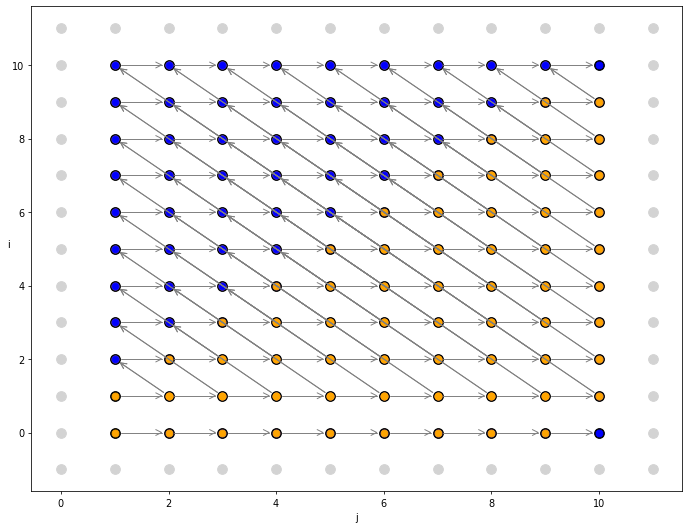

In [23]:
param = isl.set("[N] -> { : N = 10 }")
domain = isl.union_set("[N] -> { S1[i,j] : 0 <= i <= N and 1 <= j <= N }")
sche = isl.union_map("{ S1[i,j] -> [i,j] }")
read = isl.union_map("[N] -> { S1[i,j] -> a[j,i]; S1[i,j] -> a[i,j-1]; }")
write = isl.union_map("{ S1[i,j] -> a[i,j] }")
info = isl.union_access_info(read)
info = info.set_must_source(write)
info = info.set_schedule_map(sche)
flow = info.compute_flow()
raw = flow.get_must_dependence().intersect_domain(domain)
print(raw)
info = isl.union_access_info(write)
info = info.set_must_source(read)
info = info.set_schedule_map(sche)
flow = info.compute_flow()
war = flow.get_must_dependence().intersect_domain(domain)
print(war)

plt.figure(figsize=(12,9), dpi=70)
plot_domain(domain.intersect_params(param).as_set(), raw.union(war).intersect_params(param).as_map())

**2. 构造tiling有效性约束:**

$$
\begin{align}
\left(\begin{array}{ll}c_i & c_j\end{array}\right) \left( \begin{array}{l} i \\ j + 1 \end{array} \right) - \left(\begin{array}{ll}c_i & c_j\end{array}\right) \left( \begin{array}{l} i \\ j  \end{array} \right) \geq 0 \\
\left(\begin{array}{ll}c_i & c_j\end{array}\right) \left( \begin{array}{l} j \\ i \end{array} \right) - \left(\begin{array}{ll}c_i & c_j\end{array}\right) \left( \begin{array}{l} i \\ j  \end{array} \right) \geq 0 \\
\left(\begin{array}{ll}c_i & c_j\end{array}\right) \left( \begin{array}{l} i \\ j \end{array} \right) - \left(\begin{array}{ll}c_i & c_j\end{array}\right) \left( \begin{array}{l} i \\ j  \end{array} \right) \geq 0 \\
\end{align}
$$

化简得到:
$$
\begin{align}
c_j & \geq 0 \\
(c_i j + c_j  i) - (c_i i + c_j  j) & \geq 0,  j > i, 0 \leq i < N, 1 \leq j < N
\end{align}
$$

由于第二个约束带有循环变量, 所以需要用Farkas引理进行化简, 基于他的依赖多面体构造出带有拉格朗日乘数的形式:
$$
\begin{array}{llll}
   CST  & N  &   i &     j & \\
    -1  & 0  &  -1 &     1 & \geq 0 \\
     0  & 0  &   1 &     0 & \geq 0 \\
     0  & 1  &  -1 &     0 & \geq 0 \\
    -1  & 0  &   0 &     1 & \geq 0 \\
     0  & 1  &   0 &    -1 & \geq 0
\end{array}
$$
得到
$$
\begin{align}
(c_j - c_i ) i &+ (c_i - c_j ) j   \\
  & \equiv   \lambda_0 + \lambda_1 (j-i-1) + \lambda_2(i) + \lambda_3(N-i) + \lambda_4(j-1) + \lambda_5(N-j) \\
  & \equiv  (-\lambda_1 + \lambda_2 - \lambda_3)i + (\lambda_1+\lambda_4-\lambda_5)j + (\lambda_0-\lambda_1+\lambda_3N-\lambda_4+\lambda_5N) \\
& \lambda_0, \lambda_1, \lambda_2, \lambda_3, \lambda_4, \lambda_5 \geq 0 \\
\end{align}
$$

此时我们可以把这个例子转换新的约束多面体:
$$
\begin{align}
c_j - c_i & = -\lambda_1 + \lambda_2 - \lambda_3 \\
c_i - c_j & = \lambda_1+\lambda_4-\lambda_5 \\
\lambda_0-\lambda_1-\lambda_4 & = 0 \\
\lambda_3 = 0 \\
\lambda_5 = 0 \\
\lambda_0, \lambda_1, \lambda_2, \lambda_4 &\geq 0
\end{align}
$$

此时使用isl来辅助进行化简, 因为isl自带了消元的功能:


In [24]:
isl.map("{ [l0,l1,l2,l3,l4,l5] -> [ci,cj] : cj - ci = -l1+l2-l3 and ci-cj = l1+l4-l5 and 0 = l0 - l1 - l4 and l0 >= 0 and l1 >= 0 and l2 >=0 and l3 = 0 and l4 >= 0 and l5 = 0 }").range()

isl.set("{ [ci, cj] : cj <= ci }")

经过化简, 得到的约束为
$$
  c_i - c_j \geq 0
$$

**3. 添加通信量上界约束:**

首先是第一个约束是线性形式, 所以此时结构化参数为0, 只存在常量$w$:

$$
\begin{align}
w - c_j & \geq 0
\end{align}
$$

第二个约束带有循环变量, 所以需要同样需要使用Farkas引理进行优化:

$$
\begin{align}
u_1 N + w & - (c_j - c_i ) i - (c_i - c_j ) j   \\
  & \equiv   \lambda_0 + \lambda_1 (j-i-1) + \lambda_2(i) + \lambda_3(N-i) + \lambda_4(j-1) + \lambda_5(N-j) \\
  & \equiv  (-\lambda_1 + \lambda_2 - \lambda_3)i + (\lambda_1+\lambda_4-\lambda_5)j + (\lambda_0-\lambda_1+\lambda_3N-\lambda_4+\lambda_5N) \\
& \lambda_0, \lambda_1, \lambda_2, \lambda_3, \lambda_4, \lambda_5 \geq 0
\end{align}
$$

再次转换为约束多面体形式:
$$
\begin{align}
c_i - c_j &= -\lambda_1 + \lambda_2 - \lambda_3 \\
c_j - c_i &= \lambda_1+\lambda_4-\lambda_5 \\
u_1 &= \lambda_3 + \lambda_5 \\
w &= \lambda_0-\lambda_1-\lambda_4\\
\lambda_0, \lambda_1, \lambda_2, \lambda_3, \lambda_4, \lambda_5 &\geq 0
\end{align}
$$

然后使用isl辅助化简:


In [25]:
isl.map("{ [l0,l1,l2,l3,l4,l5] -> [u1,w,ci,cj] : ci-cj=-l1+l2-l3 and cj-ci=l1+l4-l5 and u1 = l3+l5 and w=l0-l1-l4 and l0 >= 0 and l1 >= 0 and l2 >= 0 and l3 >= 0 and l4 >= 0 and l5 >= 0 }").range()

isl.set("{ [u1, w, ci, cj] : u1 >= 0 and cj >= -u1 + ci and cj >= -u1 - w + ci }")

经过化简得到的约束项为:
$$
\begin{align}
u_1 &\geq 0 \\
c_j + u_1 - c_i &\geq 0 \\
c_j + u_1 + w - c_i & \geq 0
\end{align}
$$

**4. 添加非零解约束:**

$$
c_i + c_j \geq 1
$$

**5. 求解仿射变换**

首先列出所有的约束条件:
$$
\begin{align}
c_j & \geq 0 \ \text{依赖1的有效性约束} \\
c_i - c_j & \geq 0\ \text{依赖2的有效性约束}\\
w - c_j & \geq 0\ \text{依赖1的通信量约束} \\
u_1 &\geq 0\ \text{依赖2的通信量约束}\\
c_j + u_1 - c_i &\geq 0 \\
c_j + u_1 + w - c_i & \geq 0 \\
c_i + c_j - 1 & \geq 0 \ \text{非零解约束}
\end{align}
$$

求解第一行: 
$$
minimize_{\prec}(u1,w,c_i,c_j)
$$

同样使用isl来帮助我们求解:

In [26]:
isl.set("{ [u1,w,ci,cj] : cj >= 0 and ci-cj >= 0 and w - cj >= 0 and u1 >= 0 and cj + u1 - ci >= 0 and cj + u1 + w - ci >= 0 and ci + cj -1 > 0  }").lexmin()

isl.set("{ [u1 = 0, w = 1, ci = 1, cj = 1] }")

得到解:
$$
H_S = \left(\begin{array}{ll} c_i & c_j \end{array}\right) = \left(\begin{array}{ll} 1 & 1 \end{array}\right) 
$$
求解正交补矩阵:
$$
H_S^{\bot} = I - H_S^T(H_S H_S^T)^{-1}H_S = \left(\begin{array}{ll} 0.5 & -0.5 \\  -0.5 & 0.5  \end{array}\right)
$$

通过正交补矩阵获得下一个超平面的约束, 观察可以发现正交补矩阵的两行其实是线性相关的, 下面的约束只需要用第一行计算即可, 并且为了保持整型将正交补矩阵的系数归一化了:
$$
\begin{align}
\forall i,  {H^i}_S^{\bot}.  \vec{h}^*_S \geq 0 \  &\wedge \ \sum_i {H^i}_S^{\bot} . \vec{h}^*_S \geq 1  \\ 
&\implies 0.5c_i - 0.5c_j  \geq 1 \\
&\implies c_i - c_j  \geq 2
\end{align}
$$

加入这个约束再次求解:


In [27]:
isl.set("{ [u1,w,ci,cj] : cj >= 0 and ci-cj >= 0 and w - cj >= 0 and u1 >= 0 and cj + u1 - ci >= 0 and cj + u1 + w - ci >= 0 and ci + cj -1 > 0 and ci - cj >= 2 }").lexmin()

isl.set("{ [u1 = 2, w = 0, ci = 2, cj = 0] }")

最终得到调度变换矩阵为:
$$
\begin{aligned}
& T_{S_1}\left(\vec{i}_{S_1}\right)=\left(\begin{array}{ll}
1 & 1 \\
2 & 0 \\
\end{array}\right)\left(\begin{array}{l}
i \\
j \\
\end{array}\right)
\end{aligned}
$$

下面我们绘制变换后的依赖约束, 以及tiling:

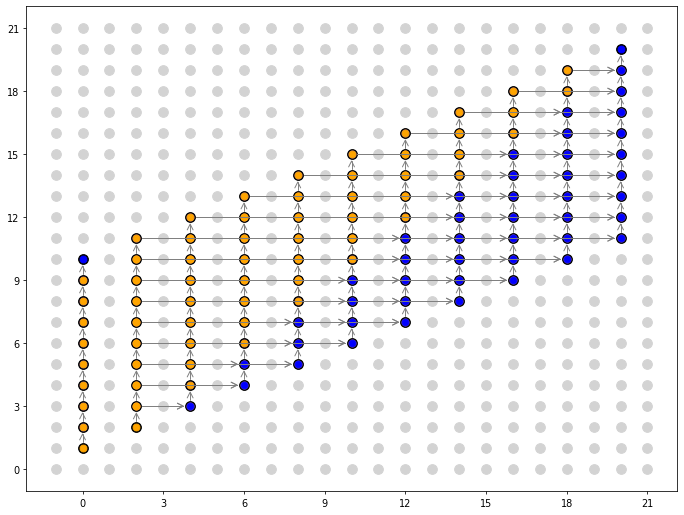

In [28]:
plt.figure(figsize=(12,9), dpi=70)
plot_domain(domain.intersect_params(param).as_set(), raw.union(war).intersect_params(param).as_map(), space=isl.map("{S1[i,j]->S1[i+j,2i]}"))

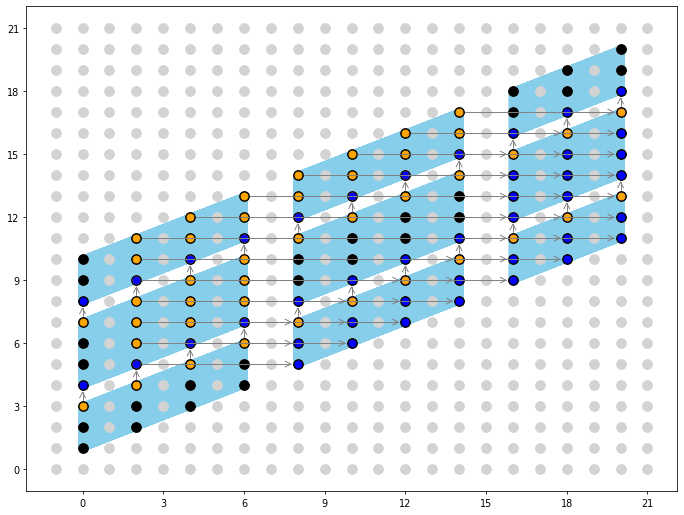

In [29]:
plt.figure(figsize=(12,9), dpi=70)
plot_domain(domain.intersect_params(param).as_set(), raw.union(war).intersect_params(param).as_map(), space=isl.map("{S1[i,j]->S1[i+j,2i]}"), tiling=isl.basic_map("{ S1[t,i] -> [floor(t/4),floor(i/4)] }"))

# 参考文献

1. Bondhugula, Uday Kumar. Effective automatic parallelization and locality optimization using the polyhedral model. Diss. The Ohio State University, 2008.
2. [零基础入门PLUTO的自动循环变换算法](https://zhuanlan.zhihu.com/p/631634938) 流霞祭司曌鹓鶵
3. 《多面体编译理论与深度学习实践》赵捷、李宝亮

# 系列文章

[[教程翻译] Polyhedral Tutorials](https://zhuanlan.zhihu.com/p/553703704)

[[Hands-On Polyhedral] C CodeGen](https://zhuanlan.zhihu.com/p/644188920)

[[Hands-On Polyhedral] Isl Concept](https://zhuanlan.zhihu.com/p/646406752)

[[Hands-On Polyhedral] Loop Transformation](https://zhuanlan.zhihu.com/p/646607576)

[[Hands-On Polyhedral] Dependence Analysis](https://zhuanlan.zhihu.com/p/651475686)

[[Hands-On Polyhedral] Tiramisu internals](https://zhuanlan.zhihu.com/p/664107908)

本文源码位于
[pluto](https://github.com/zhen8838/isl_learn/blob/main/13_pluto.ipynb)